In [23]:
import pandas as pd
import numpy as np
from sklearnex import patch_sklearn
patch_sklearn()
from seaborn import pairplot
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import SGDRegressor
from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.ensemble import IsolationForest,  GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
import copy
from sklearn.metrics import r2_score, mean_squared_error, pairwise_distances

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
torch.set_default_device(device)

#### Useful tools to evaluate model performance

In [77]:
def model_scorer(pred_model, x_train, y_train, cv = 3):
    pred_model.fit(x_train, y_train)
    normal_score = pred_model.score(x_train, y_train)
    rand_y = y_train.sample(frac = 1)
    pred_model.fit(x_train, rand_y)
    shuffle_score = pred_model.score(x_train, rand_y)
    pred_model.fit(x_train, y_train)
    cv_score = cross_validate(pred_model, x_train, y_train, cv = cv)
    return[normal_score, shuffle_score, cv_score]

In [78]:
all_fp_data = pd.read_csv("fp_dataframe.csv")
all_data = pd.read_csv("molecules_descriptors_mordred.csv")
print(all_data.shape)
# tox_outlier = np.argmax(all_data["compound_toxicity"])
#all_data = all_data.drop(tox_outlier)
fp_data =  all_fp_data.drop(all_fp_data.columns[[0, 1, -1]], axis=1)
# fp_data = fp_data.drop(tox_outlier)
pw_dist = pairwise_distances(fp_data, n_jobs = -1)
avg_pw_dist = np.mean(pw_dist, axis=0).reshape(-1, 1)
scaler = StandardScaler()
all_data.insert(3, "avg_pw_dist", avg_pw_dist)
X_train, X_test, y_train, y_test = train_test_split(all_data.drop(all_data.columns[[0, 1, -1]], axis=1), all_data.iloc[:,-1],
                                                    test_size=0.4, random_state=2)
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.fit_transform(X_test)

(366, 735)


c:\Users\serra\anaconda3\envs\data_analysis\Lib\site-packages\daal4py\sklearn\utils\validation.py:264: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any():


Tried some feature engineering - pairwise distances from fingerprint and add avergadge distance as feature

### Find out a bit about the data - correlation

In [79]:
all_data_corr = all_data.drop(all_data.columns[[0,1]], axis = 1).corr(method="spearman")

Feature with highest (monotonic) correlation + its correlation

In [80]:
my_features = all_data_corr["compound_toxicity"][np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))].iloc[::-1][1:300].index.to_list()

C:\Users\serra\AppData\Local\Temp\ipykernel_15148\1691819123.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  my_features = all_data_corr["compound_toxicity"][np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))].iloc[::-1][1:300].index.to_list()


In [81]:
my_features += ["compound_toxicity"]

In [82]:
my_features

['SLogP',
 'FilterItLogS',
 'ZMIC1',
 'ZMIC0',
 'LabuteASA',
 'SZ',
 'ATS0p',
 'Sm',
 'MW',
 'SMR',
 'Xp-0dv',
 'ATS0v',
 'ATS1Z',
 'Xp-1dv',
 'Xp-3dv',
 'ATS1m',
 'Xp-6dv',
 'Xp-5dv',
 'Xp-4dv',
 'VMcGowan',
 'ZMIC2',
 'ATS4Z',
 'ATS3Z',
 'ECIndex',
 'ATS4m',
 'ATS5m',
 'Xp-2dv',
 'ATS2p',
 'WPath',
 'mZagreb2',
 'ATS3m',
 'ATS2v',
 'ATS2Z',
 'ATS5Z',
 'Xp-1d',
 'nHeavyAtom',
 'Xp-0d',
 'ATS3p',
 'ATS1v',
 'ATS1p',
 'Kier1',
 'Xp-7dv',
 'Radius',
 'ATS3v',
 'SRW02',
 'nBondsO',
 'VAdjMat',
 'MWC01',
 'ATS2m',
 'Diameter',
 'ATS0Z',
 'Sv',
 'fragCpx',
 'ATS0m',
 'ATS1d',
 'WPol',
 'Sp',
 'apol',
 'Xp-6d',
 'TMPC10',
 'MWC02',
 'Zagreb1',
 'Xp-3d',
 'TMWC10',
 'MPC6',
 'ATS0d',
 'piPC1',
 'SRW04',
 'ZMIC3',
 'Zagreb2',
 'MWC03',
 'Xp-2d',
 'piPC6',
 'Xp-7d',
 'MPC2',
 'MPC7',
 'GGI4',
 'PEOE_VSA6',
 'piPC5',
 'ATS4v',
 'piPC2',
 'MPC5',
 'MPC3',
 'TpiPC10',
 'ATSC0p',
 'MWC04',
 'Xp-5d',
 'ATS4p',
 'nC',
 'piPC3',
 'ATSC0m',
 'MWC05',
 'ATSC0Z',
 'SRW06',
 'BertzCT',
 'Xp-4d',
 'piPC4',

In [83]:
all_data[my_features]

,SLogP,FilterItLogS,ZMIC1,ZMIC0,LabuteASA,SZ,ATS0p,Sm,MW,SMR,...,AMW,nRot,MZ,ATS4i,SaasC,AATSC0d,AATS2dv,ATS3i,SIC5,compound_toxicity
0,0.5694,-0.646644,14.568922,22.500868,37.109145,8.000000,15.998911,7.335443,88.052429,22.3070,...,6.289459,1,0.571429,1875.486620,0.000000,0.346939,2.818182,3489.341538,0.784069,2.583
1,0.7855,-1.182035,25.853911,29.317329,53.297758,10.666667,24.487794,10.085671,121.052764,34.9599,...,7.565798,1,0.666667,3950.467113,0.553241,0.496094,5.750000,4521.729919,0.968750,2.263
2,2.9359,-3.006361,25.931763,37.170610,63.820310,13.333333,33.746336,11.842644,142.135765,44.0570,...,5.076277,6,0.476190,9488.115242,0.000000,0.275510,1.098039,10967.070397,0.647045,3.662
3,1.8978,-2.253967,25.487073,38.555991,65.801297,13.333333,30.832637,12.503289,150.068080,42.9985,...,7.146099,3,0.634921,5177.492792,1.478290,0.439909,4.647059,6176.706430,0.926767,3.728
4,1.5608,-1.400866,23.096582,33.113603,57.087305,11.666667,29.178985,10.506952,126.104465,38.9818,...,5.482803,4,0.507246,7638.837378,0.000000,0.298677,1.615385,8562.993733,0.877406,5.485
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
361,2.0714,-2.565100,35.910392,37.859336,52.378934,12.333333,24.846965,12.273999,145.945683,31.0810,...,13.267789,2,1.121212,1613.188346,0.000000,0.413223,0.654321,3038.555927,0.684657,3.408
362,2.2442,-2.690141,26.951706,29.719780,48.440610,11.000000,24.217303,10.574307,126.000306,30.6740,...,9.000022,3,0.785714,3089.228525,0.000000,0.204082,0.462963,4568.183680,0.587265,3.391
363,1.6034,-1.841310,24.979470,43.064197,70.595531,14.666667,31.475841,13.835318,166.062994,44.6633,...,7.548318,3,0.666667,5854.768783,0.903519,0.520661,5.885714,6483.926721,0.931148,3.278
364,0.5410,-0.517072,22.625565,24.453803,32.395033,8.333333,8.485590,8.329049,100.013599,13.1408,...,11.112622,0,0.925926,710.768858,0.000000,0.913580,16.076923,2656.289253,0.763230,2.924


In [84]:
all_fp_data = pd.read_csv("fp_dataframe.csv")
all_data = pd.read_csv("molecules_descriptors_mordred.csv")
print(all_data.shape)
# tox_outlier = np.argmax(all_data["compound_toxicity"])
#all_data = all_data.drop(tox_outlier)
fp_data =  all_fp_data.drop(all_fp_data.columns[[0, 1, -1]], axis=1)
# fp_data = fp_data.drop(tox_outlier)
pw_dist = pairwise_distances(fp_data, n_jobs = -1)
avg_pw_dist = np.mean(pw_dist, axis=0).reshape(-1, 1)
scaler = StandardScaler()
all_data.insert(3, "avg_pw_dist", avg_pw_dist)
all_data = all_data[my_features]
X_train, X_test, y_train, y_test = train_test_split(all_data.drop(all_data.columns[-1], axis=1), all_data.iloc[:,-1],
                                                    test_size=0.4, random_state=2)
scaled_x_train = scaler.fit_transform(X_train)
scaled_x_test = scaler.fit_transform(X_test)

(366, 735)


c:\Users\serra\anaconda3\envs\data_analysis\Lib\site-packages\daal4py\sklearn\utils\validation.py:264: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  array.dtypes.apply(is_sparse).any():


In [85]:
print(all_data_corr.index[np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))][-2])
all_data_corr["compound_toxicity"][np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))][-2]

SLogP


C:\Users\serra\AppData\Local\Temp\ipykernel_15148\1413788054.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_data_corr["compound_toxicity"][np.argsort(np.abs(all_data_corr["compound_toxicity"].to_numpy()))][-2]


0.7677753489317525

Histogram of $log(\frac{1}{LC_{50}})$\
$LC_{50}$ -> the lower the more toxic, $\frac{1}{LC_{50}}$ -> the higher the more toxic

Text(0.5, 1.0, 'Test dataset compound toxicity')

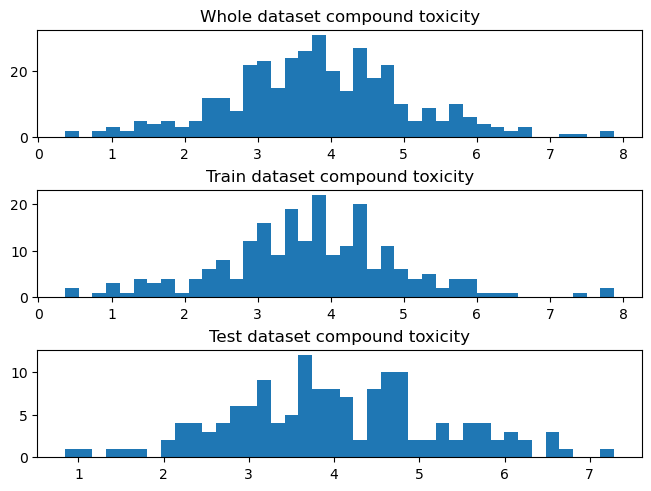

In [86]:
fig, axs = plt.subplots(3, 1, layout='constrained')#, sharex=True)
axs[0].hist(all_data["compound_toxicity"], bins = 40)
axs[1].hist(y_train, bins = 40)
axs[2].hist(y_test, bins = 40)
axs[0].set_title("Whole dataset compound toxicity")
axs[1].set_title("Train dataset compound toxicity")
axs[2].set_title("Test dataset compound toxicity")

Few super toxic compounds

#### Linear predictors

Starting with simple linear models with a shitty result (R^2)

In [87]:
sdg_regressor = SGDRegressor(max_iter=1000, tol=1e-20)
sdg_regressor.fit(scaled_x_train, y_train)
sdg_regressor.score(scaled_x_train, y_train)

-2301517.5229385532

GLMs

In [88]:
clf1 = linear_model.PoissonRegressor(max_iter=10000)
clf1.fit(scaled_x_train, y_train)
print(clf1.score(scaled_x_train, y_train))

clf2 = linear_model.TweedieRegressor()
clf2.fit(scaled_x_train, y_train)
print(clf2.score(scaled_x_train, y_train))

clf3 = linear_model.GammaRegressor()
clf3.fit(scaled_x_train, y_train)
print(clf3.score(scaled_x_train, y_train))

0.7603014887029105
0.7708482072361175
0.6351088194457397


In [89]:
clf1_pred = clf1.predict(scaled_x_train)
print(r2_score(y_train, clf1_pred))
mean_squared_error(y_train, clf1_pred)

0.8047789912970826


0.2988186741687758

In [91]:
model_scorer(clf1, scaled_x_train, y_train, cv=4)

[0.7603014887029105,
 0.25810271374620575,
 {'fit_time': array([0.01603007, 0.0170002 , 0.01599956, 0.01699972]),
  'score_time': array([0.       , 0.       , 0.0009985, 0.       ]),
  'test_score': array([0.51895041, 0.47113624, 0.77282594, 0.71225238])}]

Forward feature selection with 3 x CV

In [138]:
sfs = SequentialFeatureSelector(clf1, n_features_to_select=20, direction="forward", cv = 3, n_jobs=-1,
                                scoring="r2")
sfs.fit(scaled_x_train, y_train)
clf1.fit(scaled_x_train[:,sfs.get_support()], y_train)
clf1.score(scaled_x_train[:,sfs.get_support()], y_train)

0.6028608359690674

In [49]:
sfs.get_feature_names_out()

array(['x150', 'x151', 'x163', 'x220', 'x255', 'x259', 'x277', 'x313',
       'x326', 'x355', 'x359', 'x434', 'x484', 'x522', 'x587', 'x631',
       'x674', 'x676', 'x691', 'x731'], dtype=object)

In [263]:
model_scorer(clf1, scaled_x_train, y_train, cv=3)

[0.7603014887029105,
 0.1805352501700932,
 {'fit_time': array([0.01600099, 0.01900125, 0.01899862]),
  'score_time': array([0.        , 0.00099993, 0.        ]),
  'test_score': array([0.52313424, 0.650864  , 0.72451179])}]

In [264]:
clf1_pred = clf1.predict(scaled_x_test)
r2_score(clf1_pred, y_test)

0.4739750355457337

MultiTaskElasticNetCV

In [140]:
clf = linear_model.ElasticNetCV(cv=3, max_iter=10000)
clf.fit(scaled_x_train, y_train)
print(clf.score(scaled_x_train, y_train))

0.7159210240552529


#### Continuing with Support Vector Regression

In [97]:
svr = GridSearchCV(
    SVR(gamma=0.1),
    param_grid={"C": [1e0, 1e1, 1e2, 1e4, 1e5, 1e50], "gamma": np.logspace(-2, 1, 2, 4), "kernel":["poly", "rbf"]},
)
svr.fit(scaled_x_train, y_train)
svr.best_score_

0.6293886261845583

### Trying out NN

Training function

In [70]:
def train_nn_model(nn_model, train_data_features, train_data_res, test_data_features, test_data_res,
                   n_epochs = 20, batch_size = 5, lr = 0.0001):

    batch_start = torch.arange(0, len(X_train), batch_size)
    X_train_torch = torch.tensor(train_data_features, dtype=torch.float32)
    print(X_train_torch.device)
    y_train_torch = torch.tensor(train_data_res.to_list(), dtype=torch.float32).reshape(-1, 1)
    print(y_train_torch.device)
    X_test_torch = torch.tensor(test_data_features, dtype=torch.float32)
    print(X_test_torch.device)
    y_test_torch = torch.tensor(test_data_res.to_list(), dtype=torch.float32).reshape(-1, 1)
    print(y_test_torch.device)
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(nn_model.parameters(), lr = lr)
    
    train_history = []
    test_history = []
    last_epoch = 0
    # training loop
    best_r2 = -np.inf
    for epoch in range(n_epochs):
        nn_model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train_torch[start:start+batch_size]
                y_batch = y_train_torch[start:start+batch_size]
                # forward pass
                y_pred = nn_model(X_batch)[0]
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        if epoch - last_epoch >= 100:
            print(f"Epoch: {epoch}")
            last_epoch = epoch
        nn_model.eval()
        y_pred_test = nn_model(X_test_torch)[0].reshape((-1))
        r2_test = r2_score(y_pred_test.cpu().detach().numpy(), y_test_torch.cpu().detach().numpy())
        r2_test = float(r2_test)
        test_history.append(r2_test)


        y_pred_train = nn_model(X_train_torch)[0].reshape((-1))
        r2_train = r2_score(y_pred_train.cpu().detach().numpy(), y_train_torch.cpu().detach().numpy())
        r2_train = float(r2_train)
        train_history.append(r2_train)
        if r2_test > best_r2:
            best_r2 = r2_test
            best_weights = copy.deepcopy(nn_model.state_dict())
    
    # restore nn_model and return best accuracy
    nn_model.load_state_dict(best_weights)
    return [train_history, test_history]

In [55]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.fc1 = nn.Linear(input_size, int(input_size/2))
        self.fc2 = nn.Linear(int(input_size/2), int(input_size/4))
        self.act = nn.LeakyReLU()
        self.rnn = nn.RNN(int(input_size/4), hidden_dim, n_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, self.hidden_dim)
        return hidden

In [ ]:
class conv_rnn_Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.fc1 = nn.Linear(input_size, int(input_size/2))
        # self.fc2 = nn.Linear(int(input_size/2), int(input_size/4))
        self.act = nn.LeakyReLU()
        self.rnn = nn.RNN(int(input_size/4), hidden_dim, n_layers, batch_first=False)
        self.conv = nn.Conv1d(in_channels=int(input_size/2), )
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, self.hidden_dim)
        return hidden

In [56]:
no_features = len(my_features)-1

In [57]:
# Define the model
seq_model = nn.Sequential(
    nn.Linear(no_features, int(no_features/2)),
    nn.LeakyReLU(),
    nn.Linear(int(no_features/2), int(no_features/4)),
    nn.LeakyReLU(),
    nn.Linear(int(no_features/4), int(no_features/8)),
    nn.LeakyReLU(),
    nn.Linear(int(no_features/8), 1)
)
rnn_model = Model(no_features, 1, hidden_dim=80, n_layers=2)

In [19]:
seq_train_history, seq_test_history = train_nn_model(seq_model, scaled_x_train, y_train, scaled_x_test, y_test, n_epochs = 200, batch_size=1)

cuda:0
cuda:0
cuda:0
cuda:0
Epoch: 100


In [92]:
rnn_train_history, rnn_test_history = train_nn_model(rnn_model, scaled_x_train, y_train, scaled_x_test, y_test, n_epochs = 100, batch_size=1)

cuda:0
cuda:0
cuda:0
cuda:0


In [20]:
print(f"Seq best test: {max(seq_test_history)}")
print(f"Seq best train: {max(seq_train_history)}")

Seq best test: 0.3406274592752666
Seq best train: 0.9638771855614358


In [93]:
print(f"RNN best test: {max(rnn_test_history)}")
print(f"RNN best train: {max(rnn_train_history)}")

RNN best test: 0.6410764772559479
RNN best train: 0.9544432087445551


Text(0.5, 1.0, 'RNN Mode test R2')

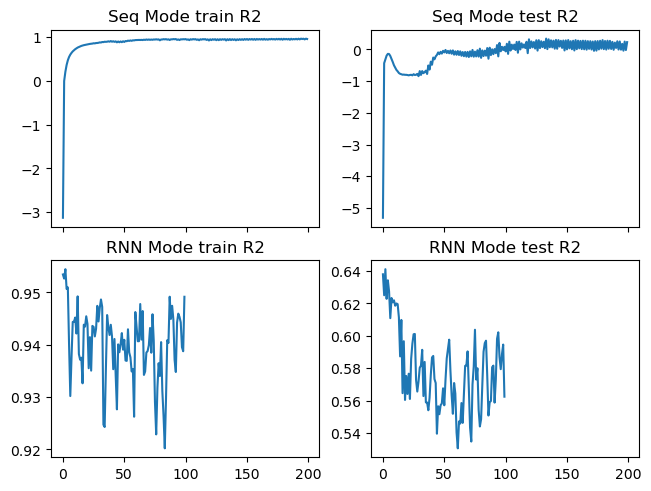

In [94]:
fig, axs = plt.subplots(2, 2, layout='constrained', sharex=True)
axs[0,0].plot(seq_train_history)
axs[0,0].set_title("Seq Mode train R2")
axs[0,1].plot(seq_test_history)
axs[0,1].set_title("Seq Mode test R2")  
axs[1,0].plot(rnn_train_history)
axs[1,0].set_title("RNN Mode train R2")
axs[1,1].plot(rnn_test_history)
axs[1,1].set_title("RNN Mode test R2")

#### Gradient Boosting

In [47]:
params = {
    "n_estimators": [10, 100, 1000, 2000],
    "max_depth": [8,12, 20, None],
    "min_samples_split": [2,5],
    "learning_rate": [0.01, 0.001, 0.1],
    "loss": ["squared_error"],
}
reg = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8)
#reg.fit(scaled_x_train, y_train)

In [48]:
CV_gbc = GridSearchCV(estimator=reg, param_grid=params, n_jobs=-1, cv= 2)

In [49]:
CV_gbc.fit(scaled_x_train, y_train)
CV_gbc.best_params_, CV_gbc.best_score_

({'learning_rate': 0.01,
  'loss': 'squared_error',
  'max_depth': 8,
  'min_samples_split': 5,
  'n_estimators': 2000},
 0.5206883701031071)

In [39]:
reg = GradientBoostingRegressor(learning_rate=0.01, max_depth=12, min_samples_split=2, n_estimators=1000)
reg.fit(scaled_x_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=12, n_estimators=1000)

In [40]:
reg.score(scaled_x_train, y_train)

0.9999999981342598

In [41]:
reg.score(scaled_x_test, y_test)

0.45319957502284924

### GP

In [30]:
kernel = kernels.RBF(1.0, length_scale_bounds=(1e-3, 1e5))*1.0
gp_rbf = GaussianProcessRegressor(kernel=kernel, random_state=1).fit(scaled_x_train, y_train)

In [31]:
gp_rbf.score(scaled_x_train, y_train)

1.0